In [1]:
import os
import PIL
device='cuda'
from PIL import Image
from torch.utils.data import Dataset,DataLoader
from torch.nn import Module
from torch.optim import AdamW
import json
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch import nn
from torchvision import transforms

In [2]:
alphabet=[symb for symb in '_ABEKMHOPCTYX0123456789']
let2int={i:let for let,i in enumerate(alphabet)}
int2let={let:i for let,i in enumerate(alphabet)}

In [3]:
#удаление ненужного
path='//home/artemybombastic/MyGit/VehicleNumberData/VNR_Data/train/img'
for file in os.listdir(path):
    if 'Unknown' in file or file.count('_')>1:
        os.remove(os.path.join(path,file))
path='//home/artemybombastic/MyGit/VehicleNumberData/VNR_Data/train/ann'
for file in os.listdir(path):
    if 'Unknown' in file or file.count('_')>1:
        os.remove(os.path.join(path,file))
    if file.count('_')>1:
        os.remove(os.path.join(path,file))
    

In [4]:
class NumberDataset(Dataset):
    def __init__(self,path,number_len):
        super(NumberDataset,self).__init__()
        self.number_len=number_len
        img_path=os.path.join(path,'img')
        label_path=os.path.join(path,'ann')

        #номера
        self.image_numbers=[img[:-4] for img in os.listdir(img_path)]
        self.label_numbers=[label[:-5] for label in os.listdir(label_path)]
        
        #изображения и лейблы 
        self.images=[os.path.join(img_path,img) for img in os.listdir(img_path) if img[:-4] in self.label_numbers]
        self.labels=[os.path.join(label_path,label) for label in os.listdir(label_path) if label[:-5] in self.image_numbers]
        
        self.images.sort(reverse=True)
        self.labels.sort(reverse=True)

        self.trans=transforms.Compose([
            transforms.Resize((64,128)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.images)
    def __getitem__(self,idx):
        idx_img=Image.open(self.images[idx]).convert('RGB')
        idx_label=self.labels[idx]
        
        with open(idx_label,'r') as file_option:
            jf=json.load(file_option)
            #return jf['name'][0:self.number_len]
            tensor_label=torch.tensor([let2int[let] for let in jf['description'][0:self.number_len] if let!='_'])
        tensor_img=self.trans(idx_img)
        return {
            'img':tensor_img,
            'label':tensor_label,
            'label_len':len(tensor_label)
        }

In [5]:
for i in range(10000):
    a=[let for let in number_data[i] if let!='_']
    print(a)

NameError: name 'number_data' is not defined

In [6]:
def collate_fn(batch):
    imgs = torch.stack([x['img'] for x in batch])
    labels=[x['label'] for x in batch]
    label_lens=torch.tensor([x['label_len'] for x in batch])
    label = torch.cat(labels)
    return imgs,label,label_lens

In [7]:
number_data=NumberDataset('//home/artemybombastic/MyGit/VehicleNumberData/VNR_Data/train',9)
number_dataloader=DataLoader(number_data,batch_size=16,shuffle=False,drop_last=True,collate_fn=collate_fn)

In [23]:
for i in number_data[5]['label']:
    print(int2let[i.item()])

Y
9
9
9
P
X
1
9
7


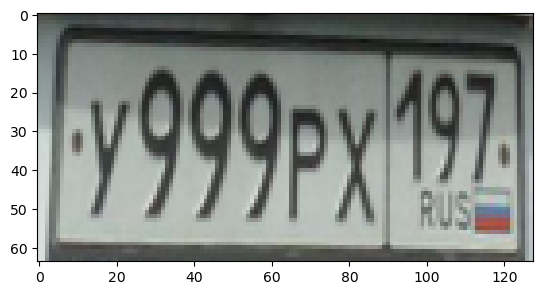

In [24]:
plt.imshow(number_data[5]['img'].permute(1,2,0).detach())

In [8]:
class ResnetBlock(Module):
    def __init__(self,input_size,output_size,stride=1,downsample=None):#downsample нужно в случае понижения размерности блока):
        super().__init__()
        self.act=nn.ReLU(inplace=True)
        self.conv0=nn.Conv2d(input_size,output_size,kernel_size=3,stride=stride,padding=1)
        self.norm0=nn.BatchNorm2d(output_size)

        self.conv1=nn.Conv2d(output_size,output_size,kernel_size=3,stride=1,padding=1)
        self.norm1=nn.BatchNorm2d(output_size)

        self.downsample=downsample
    def forward(self,x):
        out=self.conv0(x)
        out=self.norm0(out)
        out=self.act(out)
        out=self.conv1(out)
        out=self.norm1(out)
        if self.downsample:
            x=self.downsample(x)
        out+=x
        out=self.act(out)

        return out
        
        

In [9]:
def make_layers(block,cnt,input_size,output_size,stride=1,downsample=False):
    blocks=[]

    if downsample or input_size!=output_size or stride!=1:
        downsample=nn.Sequential(
            nn.Conv2d(input_size,output_size,1,stride,bias=False),
            nn.BatchNorm2d(output_size)
        )

    blocks.append(block(input_size,output_size,stride,downsample))    
    for i in range(1,cnt):
        blocks.append(block(output_size,output_size))

    return nn.Sequential(*blocks)
    

In [10]:
class Resnet34(Module):
    def __init__(self,input_size,hidden_size):
        super().__init__()

        self.initial_lay=nn.Sequential(
            nn.Conv2d(input_size,hidden_size,kernel_size=7,stride=2,padding=3),
            nn.BatchNorm2d(hidden_size),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3,stride=2,padding=1)
        )

        self.lay0=make_layers(block=ResnetBlock,cnt=3,input_size=hidden_size,output_size=hidden_size,downsample=False)
        self.lay1=make_layers(block=ResnetBlock,cnt=4,input_size=hidden_size,output_size=hidden_size*2,stride=(2,1),downsample=True)
        self.lay2=make_layers(block=ResnetBlock,cnt=6,input_size=hidden_size*2,output_size=hidden_size*4,stride=(2,1),downsample=True)
        self.lay3=make_layers(block=ResnetBlock,cnt=3,input_size=hidden_size*4,output_size=hidden_size*8,stride=(2,1),downsample=True)

        self.avg_pool=nn.AdaptiveAvgPool2d((1,None))
        
    def forward(self,x):
        #print(x.shape)
        out=self.initial_lay(x)
        #print(out.shape)
        #print('СЛОИ:')
        out=self.lay0(out)
        #print(out.shape)
        out=self.lay1(out)
        #print(out.shape)
        out=self.lay2(out)
        #print(out.shape)
        out=self.lay3(out)
        #print(out.shape)

        final_out=self.avg_pool(out)
        #print(final_out.shape)
        return final_out

In [11]:
class CRNN(Module):
    def __init__(self,input_size,hidden_size):
        super().__init__()

        self.cnn=Resnet34(3,64)
        self.rnn=nn.LSTM(hidden_size*8,hidden_size*4,num_layers=1,bidirectional=True)
        self.final_lay=nn.Sequential(    
            nn.Linear(512,len(alphabet))
        )
                
    def forward(self,x):
        out=self.cnn(x)

        out=out.squeeze(2).permute(2,0,1)
        out,_=self.rnn(out)

        out=self.final_lay(out)

        #финальная размерность длина_строки*batch*размер_алфвавита

        return out

In [12]:
loss_fn=nn.CTCLoss(blank=0)
model=CRNN(input_size=3,hidden_size=64).to(device)

#weight_path='/home/artemybombastic/MyGit/VehicleNumberData/VNR_Data/weights/crnn_weights'

if f'crnn_weights.pth' in os.listdir('../VehicleNumberData/VNR_Data/weights/'):
    weights_dict=torch.load(f'../VehicleNumberData/VNR_Data/weights/crnn_weights.pth',weights_only=True)
    model.load_state_dict(weights_dict)
    print('Веса обнаружены')


optimizer=AdamW(model.parameters())

Веса обнаружены


In [76]:
model.train()
for i in range(5):
    losses=[]
    for batch in (pbar:=tqdm(number_dataloader)):
        optimizer.zero_grad()
        img,label,label_len=batch
        pred=model(img.to(device))

        T = pred.size(0)
        N = pred.size(1)
        input_len = torch.full(size=(N,), fill_value=T, dtype=torch.int32)

        
        pred=pred.log_softmax(dim=2)
        loss=loss_fn(pred,label,input_len,label_len)
        loss.backward()
        loss_item=loss.item()
        losses.append(loss_item)
        optimizer.step()
        pbar.set_description(f"loss: {loss_item}")
        
        #pbar.set_descriptiont()
    try:
        torch.save(model.state_dict(),r'../VehicleNumberData/VNR_Data/weights/crnn_weights.pth')
    except:
        print('Ошибка загрузки')
    print(f'mean_loss: {sum(losses)/len(losses)}')
        
    

loss: 0.0021813015919178724:   1%|▏         | 38/2776 [00:02<02:40, 17.08it/s]


KeyboardInterrupt: 

In [77]:
def translate(message):
    message=[int2let[i.item()] for i in message]
    return ''.join(message)

In [78]:
label=[num.item() for num in label]
corected_label=[]
for lenght in label_len:
    #print(1)
    new_label=label[:lenght]
    while len(new_label)<16:
        new_label.append(0)
    corected_label.append(torch.tensor(new_label))
    #print(label)
    label=label[lenght:]

In [84]:
for word in pred:
    print(word)

tensor([[-3.4212e-05, -1.6237e+01, -1.5520e+01, -1.5268e+01, -1.4996e+01,
         -1.5043e+01, -1.4516e+01, -1.4249e+01, -1.3667e+01, -1.5818e+01,
         -1.6941e+01, -1.0497e+01, -1.4489e+01, -1.4366e+01, -1.6445e+01,
         -1.7627e+01, -1.7849e+01, -1.4540e+01, -1.7076e+01, -1.7113e+01,
         -1.4089e+01, -1.4514e+01, -1.6688e+01],
        [-4.1961e-05, -1.5982e+01, -1.5177e+01, -1.5072e+01, -1.4886e+01,
         -1.4954e+01, -1.4566e+01, -1.4008e+01, -1.3433e+01, -1.5699e+01,
         -1.6571e+01, -1.0293e+01, -1.4159e+01, -1.4431e+01, -1.6109e+01,
         -1.7283e+01, -1.7451e+01, -1.4400e+01, -1.6955e+01, -1.6872e+01,
         -1.3774e+01, -1.4180e+01, -1.6455e+01],
        [-2.6941e-05, -1.6402e+01, -1.5599e+01, -1.5290e+01, -1.5165e+01,
         -1.4701e+01, -1.4439e+01, -1.4097e+01, -1.3645e+01, -1.5610e+01,
         -1.6572e+01, -1.0850e+01, -1.4258e+01, -1.4167e+01, -1.6708e+01,
         -1.7417e+01, -1.7650e+01, -1.4705e+01, -1.7420e+01, -1.7771e+01,
         -1.35

In [88]:
corected_pred=[]
for word in pred.argmax(dim=2).permute(1,0):
    new_word=[let.item() for let in word if let.item()!=0]
    while len(new_word)<16:
        new_word.append(0)
    corected_pred.append(torch.tensor(new_word))
    #print(torch.tensor(word)



In [104]:
[(corected_pred[i]-corected_label[i]).abs().sum().item() for i in range(len(corected_pred))]

[43, 28, 62, 39, 35, 68, 48, 53, 94, 89, 20, 21, 54, 53, 0, 77]

In [89]:
corected_label

[tensor([11, 20, 22, 13,  7,  4, 20, 22, 22,  0,  0,  0,  0,  0,  0,  0]),
 tensor([11, 20, 22, 13,  7,  2, 14, 20, 21,  0,  0,  0,  0,  0,  0,  0]),
 tensor([11, 20, 22, 13,  1,  6, 14, 13, 15,  0,  0,  0,  0,  0,  0,  0]),
 tensor([11, 20, 22, 13,  1,  1, 20, 14,  0,  0,  0,  0,  0,  0,  0,  0]),
 tensor([11, 20, 21, 22,  8,  4, 14, 19, 16,  0,  0,  0,  0,  0,  0,  0]),
 tensor([11, 20, 21, 22,  6,  4, 17, 20,  0,  0,  0,  0,  0,  0,  0,  0]),
 tensor([11, 20, 21, 22,  6,  1, 22, 21,  0,  0,  0,  0,  0,  0,  0,  0]),
 tensor([11, 20, 21, 20, 12, 12, 22, 21,  0,  0,  0,  0,  0,  0,  0,  0]),
 tensor([11, 20, 21, 20,  2,  2, 14, 19, 14,  0,  0,  0,  0,  0,  0,  0]),
 tensor([11, 20, 21, 20,  1,  9, 14, 15, 18,  0,  0,  0,  0,  0,  0,  0]),
 tensor([11, 20, 21, 19, 12,  2, 20, 20, 20,  0,  0,  0,  0,  0,  0,  0]),
 tensor([11, 20, 21, 19,  4,  6, 15, 18,  0,  0,  0,  0,  0,  0,  0,  0]),
 tensor([11, 20, 21, 18,  4, 12, 14, 19, 14,  0,  0,  0,  0,  0,  0,  0]),
 tensor([11, 20, 21, 18, 

In [113]:
((corected_pred[i]-corected_label[i])==0).sum().item()/16

0.625

In [109]:
[(corected_pred[i]-corected_label[i]).abs().item() for i in range(len(corected_pred))]

RuntimeError: a Tensor with 16 elements cannot be converted to Scalar

In [105]:
corected_pred-corected_label

TypeError: unsupported operand type(s) for -: 'list' and 'list'

In [53]:
corected_pred-corected_pred

TypeError: unsupported operand type(s) for -: 'list' and 'list'

In [ ]:
pred=pred.argmax(dim=2).permute(1,0)
pred

In [29]:
corected_label

[]

In [33]:
model.eval()
for batch in number_dataloader:
    img,label,lengt=batch
    pred=model(img.to(device))
    break

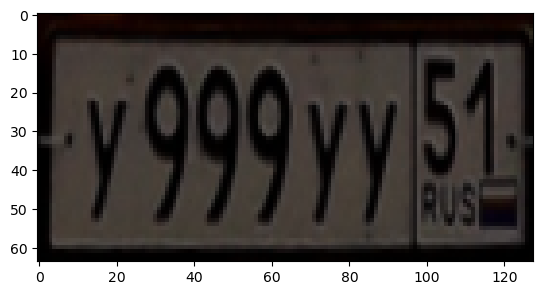

In [37]:
plt.imshow(img[0].detach().permute(1,2,0))

In [38]:
pred.argmax(dim=2).permute(1,0).shape

torch.Size([16, 32])

In [40]:
for i in pred.argmax(dim=2).permute(1,0):
    translated=translate(i)
    translated=[i for i in translated if i!='_']
    print(''.join(translated))

E999YY5511
E999XX199
E999XE1777
E999TTT98
E999TA38
E999PX1197
E999PX190
E999MP554
E999KY47
E999KT54
E999KO35
E999KC199
E999HO11977
E999HE33
E999EEY1197
E999CH1550


In [40]:
pred.argmax(dim=2)

tensor([[10, 11, 10, 11, 11, 10, 11, 10, 11, 11, 11, 11, 11, 10, 11, 11],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21],
        [10, 11,  0,  9,  9,  7,  7,  4,  0,  0,  0,  0,  0,  0,  0,  8],
        [ 0,  0,  0,  9,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  

In [28]:
pred

tensor([[[ -5.8156, -10.1061, -11.7934,  ..., -11.1123, -11.0970, -16.4119],
         [ -4.4517,  -8.7108,  -9.2992,  ...,  -9.7800, -10.0216, -14.3178],
         [ -5.4260,  -9.7582, -10.8256,  ..., -11.6554, -10.7967, -16.1162],
         ...,
         [ -5.6564, -10.3682, -11.4798,  ..., -11.8918, -11.1248, -16.4686],
         [ -5.3329,  -9.9951, -11.4480,  ..., -11.5372, -11.0739, -16.1333],
         [ -4.5062,  -7.4529,  -9.1256,  ...,  -9.8695,  -9.4654, -14.4170]],

        [[  2.0963, -17.1665, -18.1977,  ..., -15.3554, -11.2241, -20.4369],
         [  2.4715, -15.4072, -16.0101,  ..., -13.9662,  -9.8505, -18.4569],
         [  3.4724, -15.9572, -16.6267,  ..., -14.0816,  -9.9950, -18.7309],
         ...,
         [  1.9690, -16.9843, -17.3550,  ..., -15.2389, -10.7837, -19.8290],
         [  2.8730, -16.3784, -17.2954,  ..., -14.7409, -10.4135, -19.4493],
         [  3.0526, -14.5375, -16.1110,  ..., -13.7022,  -9.1202, -18.5744]],

        [[  3.2932, -18.6375, -20.7996,  ...

In [ ]:
i

In [19]:
translate(label)

'B153OO197A680BH77X596CE197P761XC90H766PX77B945XY197E221BM50O571KA190E833AA777T502CK190E232XP97A640PC77K671CK197A172HH199C423PB197O425OK77'

In [20]:
for i in pred.argmax(dim=2):
    print(translate(i))

BAXPHBEOETEAKACO
AAAAAAAAAAAAAAAA
AAAAAAAAAAAAAAAA
1657792585266144
AAAAAAAAAAAAAAAA
5896642730347722
AAAAAAAAAAAAAAAA
3061651132201235
AAAAAAAKAAAAAAAA
AAAAAAAAAAAAAAAA
AAAAAAAAAAAAAAAA
AAAAAAAAAAAAAAAA
AAAAAAAAAAAAAAAA
AAAAAAAAAAAAAAAA
AAAAAAAAAAAAAAAA
AAAAAAAAAAAAAAAA
AAAAAAAAAAAAAAAA
AAAAAAAAAAAAAAAA
AAAAAAAAAAAAAAAA
OACAAAAAAAAACHAA
ABCAPAAAACXPAAAA
AAAXPXBAAAAPAAPO
AAAAAAAAAAAAAAAA
AAAAAAAAAAAAAAAA
AAAAAAAAAAAAAAAA
AAAAAAAAAAAAAAAA
OAAAAAMAAAAAAHAA
OHEAXYMA7KPCKABK
AA1CA1AAAAAA111A
171A71A171971917
9A99A959A99A9A9A
7770770070777977


In [42]:
translate(pred.argmax(dim=2)[-1])

'6877230204334105'

In [ ]:
[int2let[i.item()] for i in pred.argmax(dim=2)[2]]